<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install dependencies

In [1]:
# Install libs
!pip install datasets transformers evaluate huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Huggingface Login

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Git config for upload model

In [3]:
# Config git
!apt install git-lfs
!git config --global user.email "pmfsl@cin.ufpe.br"
!git config --global user.name "Pedro Sena"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


Checking if transformers lib version is gratter then 4.16.0

In [4]:
import transformers

assert transformers.__version__ > '4.16.0'
print(transformers.__version__)

4.26.1


In [5]:
import json
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [6]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  1


In [7]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn')

# ASSIN2 Dataset

In [8]:
dataset = load_dataset('assin2')

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
dataset['train'][0]

{'sentence_pair_id': 1,
 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água',
 'hypothesis': 'Uma criança está segurando uma pistola de água',
 'relatedness_score': 4.5,
 'entailment_judgment': 1}

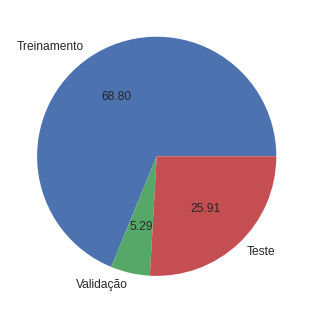

In [10]:
train_size = dataset['train'].num_rows
val_size = dataset['validation'].num_rows
test_size = dataset['test'].num_rows

plt.pie([train_size, val_size, test_size], labels=['Treinamento', 'Validação', 'Teste'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

In [11]:
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

final_df = pd.concat([train_df, val_df, test_df])

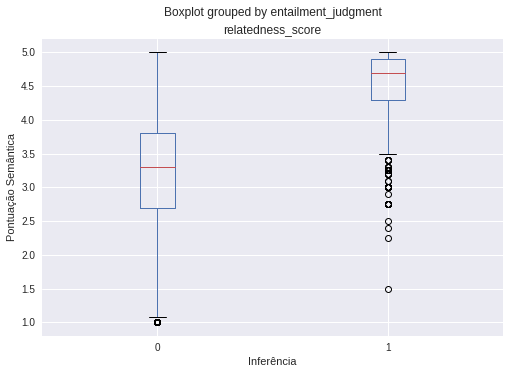

In [12]:
# scaler = MinMaxScaler()
# norm_df = final_df.copy()

# norm_df['relatedness_score'] = scaler.fit_transform(norm_df['relatedness_score'].values.reshape(-1, 1))

# box_q1 = norm_df['relatedness_score'].quantile(0.25)
# box_q3 = norm_df['relatedness_score'].quantile(0.75)
# box_iqr = box_q3 - box_q1

# lower_whisker = box_q1-1.5*box_iqr
# upper_whisker = box_q3+1.5*box_iqr

# norm_df = norm_df.query("`relatedness_score` < @upper_whisker and `relatedness_score` > @lower_whisker")  # [norm_df['relatedness_score'] < upper_whisker & norm_df['relatedness_score'] > lower_whisker]

# norm_df = norm_df[norm_df['relatedness_score'] < upper_whisker]
# norm_df = norm_df[norm_df['relatedness_score'] > lower_whisker]

final_df.boxplot(column='relatedness_score', by='entailment_judgment')

plt.xlabel('Inferência')
plt.ylabel('Pontuação Semântica')
plt.show()

# Pre-processamento

In [13]:
def get_relatedness_scores():
    scores = []
    for key in dataset.keys():
        scores.extend(dataset[key]['relatedness_score'])
    return np.array(scores)

def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
# def normalize_relatedness_score(examples):
#     scores = np.array(examples['relatedness_score'])
#     return {'label': scaler.transform(scores.reshape(-1, 1)).reshape(1, -1)[0]}

In [14]:
def pre_processing(task):
    encoded_dataset = dataset.map(encoder, batched=True)

    if task == 'stsb':
        # Normalize relatedness scores
        # scaler = MinMaxScaler()
        # scores = get_related_scores()
        # scaler.fit(scores.reshape(-1, 1))
        # encoded_dataset = encoded_dataset.map(normalize_relatedness_score, batched=True)
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['relatedness_score']}, batched=True)
    else:
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)

    pre_encoder_columns = set(dataset["train"].features)
    encoder_columns = list(set(encoded_dataset["train"].features) - pre_encoder_columns)
    
    return encoded_dataset

# Fine-tuning

In [15]:
class Metric:
    def __init__(self, task):
        self.task = task
        if self.task == 'stsb':
            self.metric = evaluate.load('pearsonr')
        else:
            self.metric = evaluate.combine(['accuracy', 'f1'])
    
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions
        if self.task == "stsb":
            predictions = predictions[:, 0]
        else:
            predictions = np.argmax(predictions, axis=1)

        return self.metric.compute(predictions=predictions, references=labels)

In [16]:
def load_model(model_checkpoint, total_train_steps, task, learning_rate):
    from_pt = True if model_checkpoint == "neuralmind/bert-large-portuguese-cased" else False
    optimizer, schedule = create_optimizer(
        init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps
    )

    if task == 'stsb':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1, from_pt=from_pt)
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
    else:
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)   
        model.compile(
                optimizer=optimizer,
        )
            
    return model

In [17]:
def load_tf_dataset(dataset, model, data_collator, batch_size):
    tf_dataset = model.prepare_tf_dataset(
        dataset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return tf_dataset

In [29]:
def load_callbacks(model_name, output_path, task):
    metric = Metric(task)
    metric_callback = KerasMetricCallback(
        metric_fn=metric.compute, eval_dataset=tf_validation_set
    )

    tensorboard_callback = TensorBoard(log_dir=f"{output_path}/logs")

    push_to_hub_callback = PushToHubCallback(
        output_dir=f'./{model_name}',
        tokenizer=tokenizer,
        hub_model_id=model_name,
        save_strategy="no"
    )

    # checkpoint_callback = ModelCheckpoint(
    #     # Path where to save the model
    #     # The two parameters below mean that we will overwrite
    #     # the current checkpoint if and only if
    #     # the `val_loss` score has improved.
    #     # The saved model name will include the current epoch.
    #     filepath=f"{output_path}/train/{push_to_hub_model_id}/epochs/" + "epoch_{epoch}",
    #     verbose=1,
    # )

    callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]
    
    return callbacks

In [19]:
def plot_loss(history, label='Loss'):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], label='Val ' + label)
  
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()
  plt.show()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();
    plt.show()

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  print('True Negatives:', cm[0][0])
  print('False Positives:', cm[0][1])
  print('False Negatives:', cm[1][0])
  print('True Positives:', cm[1][1])

In [30]:
MODELS = [
    {
        "id": "bertimbau-base-finetuned-2",
        "checkpoint": "neuralmind/bert-base-portuguese-cased"
    },
    {
        "id": "bertimbau-large-finetuned",
        "checkpoint": "neuralmind/bert-large-portuguese-cased"
    },
    {
        "id": "mbert-base-finetuned",
        "checkpoint": "bert-base-multilingual-cased"
    },
    {
        "id": "xlmr-base-finetuned",
        "checkpoint": "xlm-roberta-base"
    },
    {
        "id": "xlmr-large-finetuned",
        "checkpoint": "xlm-roberta-large"
    }
]

# Options: stsb, rte
TASK = 'rte'

# Hyperparams
LEARNING_RATES = [
    {"id": 2, "value": 2e-5}, 
    {"id": 3, "value": 3e-5}, 
    {"id": 4, "value": 4e-5}, 
    {"id": 5, "value": 5e-5},
]

BATCH_SIZES = [
    8, 
    16, 
    32,
    64
]
NUM_EPOCHS = 5

tokenizer = AutoTokenizer.from_pretrained(MODELS[0]['checkpoint'], model_max_length=train_size)
encoded_dataset = pre_processing(TASK)

for batch in BATCH_SIZES:
    batches_per_epoch = train_size // batch
    total_train_steps = int(batches_per_epoch * NUM_EPOCHS)
    for lr in LEARNING_RATES:
        # init model
        model_name = "{}-{}-{}-{}".format(MODELS[0]['id'], TASK, batch, lr['id'])
        model = load_model(MODELS[0]['checkpoint'], total_train_steps, TASK, lr['value'])
        output_path = f'./drive/MyDrive/models/{model_name}'
        
        # set dataset to tensor
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
        
        tf_train_set = load_tf_dataset(encoded_dataset['train'], model, data_collator, batch)
        tf_validation_set = load_tf_dataset(encoded_dataset['validation'], model, data_collator, batch)

        callbacks = load_callbacks(model_name, output_path, TASK)

        print(model_name)

        # huggingface_repo = Repository(local_dir=f"./drive/MyDrive/models/{model_name}", clone_from=f"pmfsl/{model_name}")
        # huggingface_repo.git_pull()
        
        # training
        history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=callbacks)
        
        # save results
        filepath = f'{output_path}/history.json'
        with open(filepath, 'w') as f:
            json.dump(history.history, f)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/content/bertimbau-base-finetuned-2-rte-8-2 is already a clone of https://huggingface.co/pmfsl/bertimbau-base-finetuned-2-rte-8-2. Make sure you pull the latest changes with `repo.git_pull()`.


bertimbau-base-finetuned-2-rte-8-2
Epoch 1/5
812/812 [==============================] - 162s 142ms/step - loss: 0.3592 - val_loss: 0.1926 - accuracy: 0.9294 - f1: 0.9275
Epoch 2/5
812/812 [==============================] - 97s 119ms/step - loss: 0.1892 - val_loss: 0.1435 - accuracy: 0.9496 - f1: 0.9501
Epoch 3/5
812/812 [==============================] - 95s 118ms/step - loss: 0.0971 - val_loss: 0.1687 - accuracy: 0.9496 - f1: 0.9507
Epoch 4/5
812/812 [==============================] - 92s 114ms/step - loss: 0.0568 - val_loss: 0.1452 - accuracy: 0.9597 - f1: 0.9603
Epoch 5/5
812/812 [==============================] - 93s 114ms/step - loss: 0.0339 - val_loss: 0.1602 - accuracy: 0.9637 - f1: 0.9641


Upload file tf_model.h5:   0%|          | 32.0k/416M [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/pmfsl/bertimbau-base-finetuned-2-rte-8-2
   bb74bbe..86da921  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/pmfsl/bertimbau-base-finetuned-2-rte-8-2
   bb74bbe..86da921  main -> main

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please p

bertimbau-base-finetuned-2-rte-8-3
Epoch 1/5
812/812 [==============================] - 162s 142ms/step - loss: 0.3656 - val_loss: 0.2023 - accuracy: 0.9234 - f1: 0.9275
Epoch 2/5
812/812 [==============================] - 96s 118ms/step - loss: 0.1831 - val_loss: 0.1502 - accuracy: 0.9556 - f1: 0.9560
Epoch 3/5
812/812 [==============================] - 97s 119ms/step - loss: 0.0939 - val_loss: 0.1616 - accuracy: 0.9496 - f1: 0.9495
Epoch 4/5
812/812 [==============================] - 96s 118ms/step - loss: 0.0533 - val_loss: 0.1699 - accuracy: 0.9617 - f1: 0.9619
Epoch 5/5
812/812 [==============================] - 94s 116ms/step - loss: 0.0291 - val_loss: 0.1817 - accuracy: 0.9657 - f1: 0.9662


Upload file tf_model.h5:   0%|          | 32.0k/416M [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/pmfsl/bertimbau-base-finetuned-2-rte-8-3
   31460f4..f636e02  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/pmfsl/bertimbau-base-finetuned-2-rte-8-3
   31460f4..f636e02  main -> main

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please p

HfHubHTTPError: ignored

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("pmfsl/bertimbau-base-finetuned-rte")
tokenizer = AutoTokenizer.from_pretrained("pmfsl/bertimbau-base-finetuned-rte")
# classifier = pipeline("text-classification", "pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2", framework="tf")

Some layers from the model checkpoint at pmfsl/bertimbau-base-finetuned-rte were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at pmfsl/bertimbau-base-finetuned-rte.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
sentences = []
for d in dataset['test']:
    text = '{}. {}'.format(d['premise'], d['hypothesis'])
    sentences.append(text)

In [ ]:
outputs = classifier(sentences)

In [ ]:
label_col = 'relatedness_score' if TASK == 'stsb' else 'entailment_judgment'
label2id = {"None": 0, "Entails": 1}
y = dataset['test'][label_col]
y_hat = [label2id[d['label']] for d in outputs]

metric.compute(predictions=y_hat, references=y)

In [ ]:
plot_confusion_matrix(y, y_hat)

In [ ]:
d = pd.DataFrame(outputs)
d.to_csv('pt_bert_rte_preds.csv')